# Text classification using pretrained word embeddings

Using the pretrained embeddings to classify text data into topics:

### Installing required libraries


In [1]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn
# !pip install gensim==4.3.3
# !pip install pyarrow

# !pip install torch==2.2.2 torchtext==0.17.2 nltk
# !pip install torchdata==0.7.1

### Importing libraries


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import Dataset
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm

%matplotlib inline
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [3]:
def find_similar_words(target_word, embedding_dict, top_k=2):
    if target_word not in embedding_dict:
        return f"Word '{target_word}' not found in embeddings."
    
    target_vector = embedding_dict[target_word]
    similarities = {}

    for word, vector in embedding_dict.items():
        if word == target_word:
            continue
        similarity = np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words[:top_k]]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# === 2. Load GloVe into a dictionary ===
def load_glove_embeddings(file_path):
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = [float(x) for x in values[1:]]
            embeddings_dict[word] = vector
    return embeddings_dict

glove_path = "glove.6B.100d.txt"
embedding_dict_Glove6B = load_glove_embeddings(glove_path)

print("Example:", list(embedding_dict_Glove6B.items())[0])

Example: ('the', [-0.038194, -0.24487, 0.72812, -0.39961, 0.083172, 0.043953, -0.39141, 0.3344, -0.57545, 0.087459, 0.28787, -0.06731, 0.30906, -0.26384, -0.13231, -0.20757, 0.33395, -0.33848, -0.31743, -0.48336, 0.1464, -0.37304, 0.34577, 0.052041, 0.44946, -0.46971, 0.02628, -0.54155, -0.15518, -0.14107, -0.039722, 0.28277, 0.14393, 0.23464, -0.31021, 0.086173, 0.20397, 0.52624, 0.17164, -0.082378, -0.71787, -0.41531, 0.20335, -0.12763, 0.41367, 0.55187, 0.57908, -0.33477, -0.36559, -0.54857, -0.062892, 0.26584, 0.30205, 0.99775, -0.80481, -3.0243, 0.01254, -0.36942, 2.2167, 0.72201, -0.24978, 0.92136, 0.034514, 0.46745, 1.1079, -0.19358, -0.074575, 0.23353, -0.052062, -0.22044, 0.057162, -0.15806, -0.30798, -0.41625, 0.37972, 0.15006, -0.53212, -0.2055, -1.2526, 0.071624, 0.70565, 0.49744, -0.42063, 0.26148, -1.538, -0.30223, -0.073438, -0.28312, 0.37104, -0.25217, 0.016215, -0.017099, -0.38984, 0.87424, -0.72569, -0.51058, -0.52028, -0.1459, 0.8278, 0.27062])


In [6]:
len(list(embedding_dict_Glove6B.items())[0][1])

100

In [7]:
# an array of example words
words = [
    "taller",
    "short",
    "black",
    "white",
    "dress",
    "pants",
    "big",
    "small",
    "red",
    "blue",
    "smile",
    "frown",
    "race",
    "stroll",
    "tiny",
    "huge",
    "soft",
    "rough",
    "team",
    "individual"
]


words_embedding_dict_Glove6B = {}

for word in words:
    embedding_vector = embedding_dict_Glove6B[word]
    if embedding_vector is not None:
        words_embedding_dict_Glove6B[word] = embedding_vector

In [8]:
# Call the function to find similar words
target_word = "small"
top_k = 4
similar_words = find_similar_words(target_word, words_embedding_dict_Glove6B, top_k)

print("{} most similar words to {}:".format(top_k, target_word), similar_words)

4 most similar words to small: ['tiny', 'big', 'huge', 'short']


build vocab from the pretrained GloVe:


In [16]:
ordered_dict = OrderedDict((word, 1) for word in embedding_dict_Glove6B.keys())

my_vocab = vocab(ordered_dict, specials=["<unk>", "<pad>"])
my_vocab.set_default_index(my_vocab["<unk>"])

In [17]:
len(my_vocab)

400002

In [18]:
my_vocab(["<unk>", "Hello", "hello"])

[0, 0, 13077]

In [36]:
list(my_vocab.get_stoi().items())[:10]

[('sandberger', 400001),
 ('rolonda', 399999),
 ('kronik', 399998),
 ('1.3775', 399995),
 ('aqm', 399994),
 ('katuna', 399993),
 ('sigarms', 399992),
 ('cipolletti', 399988),
 ('altares', 399987),
 ('slann', 399985)]

tokenize text. using pretrained tokenizers from torch:


In [19]:
tokenizer = get_tokenizer("basic_english")

Create splits from AG_NEWS() dataset for training, validation and test:


In [21]:
# Load training data
train_df = pd.read_parquet("ag_news/train.parquet")
print("Training set shape:", train_df.shape)
display(train_df.head())

# Load test data
test_df = pd.read_parquet("ag_news/test.parquet")
print("\nTest set shape:", test_df.shape)
display(test_df.head())

Training set shape: (120000, 2)


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2



Test set shape: (7600, 2)


,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [22]:
class NewsDataset(Dataset):
    def __init__(self, df):
        self.labels = df.iloc[:, 1].tolist()  # second col = label
        self.texts = df.iloc[:, 0].tolist()   # first col = text

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.labels[idx], self.texts[idx]

train_dataset_full = NewsDataset(train_df)
test_dataset = NewsDataset(test_df)

In [23]:
num_train = int(len(train_dataset_full) * 0.85)
split_train_, split_valid_ = random_split(train_dataset_full, [num_train, len(train_dataset_full) - num_train])

print(f"Train samples: {len(split_train_)}")
print(f"Valid samples: {len(split_valid_)}")
print(f"Test samples:  {len(test_dataset)}")

Train samples: 102000
Valid samples: 18000
Test samples:  7600


In [24]:
for i in range(5):
    print(split_train_[i])
    print('=' * 100)

(2, 'Borders Profits Rise, Raises Outlook  NEW YORK (Reuters) - Borders Group Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=BGP.N target=/stocks/quickinfo/fullquote"&gt;BGP.N&lt;/A&gt;, the No. 2  U.S. bookseller, on Tuesday said quarterly earnings rose,  beating estimates by the company and Wall Street, largely  because of stronger-than-expected book sales.')
(1, 'CLEVELAND PITCHER SHOT IN CALF ON TOUR BUS A pitcher for the Cleveland Indians is recovering from a shooting after Wednesday nights game. Rookie Kyle Denney was struck in his calf.')
(2, 'US Treasuries Up, Long-End Leads the Way  LONDON (Reuters) - U.S. Treasury prices crept higher on  Wednesday, with long-dated bonds benefiting from the view that  higher U.S. interest rates will help keep inflation under  control.')
(2, 'SEC Seen Making Google IPO Effective WASHINGTON (Reuters) - The US Securities and Exchange Commission is expected to declare the initial public offering registration of Google Inc. 

In [25]:
# define class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
classes = set([label for (label, text) in split_train_])
num_class = len(classes)
print(num_class)
print(classes)

4
{0, 1, 2, 3}


Collate data in batches:


In [26]:
def text_pipeline(x):
    x = x.lower()
    return my_vocab(tokenizer(x))

def label_pipeline(x):
    return int(x)

# create label, text and offset for each batch of data
# text is the concatenated text for all text data in the batch
# we need to have the offsets(the end of text index) for later when we separate texts and predict their label

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

Creating data loaders for train, validation and test splits:


In [28]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [29]:
for labels, texts, offsets in train_dataloader:
    print("Labels:", labels)
    print("Texts:", texts)
    print("Offsets:", offsets)
    break

Labels: tensor([2, 2, 0, 0, 2, 3, 1, 2, 2, 1, 1, 0, 3, 1, 2, 1, 2, 3, 1, 2, 3, 2, 0, 3,
        0, 1, 2, 2, 3, 0, 1, 3, 3, 1, 3, 2, 2, 2, 1, 0, 1, 1, 3, 0, 2, 0, 0, 2,
        3, 1, 2, 2, 1, 1, 3, 0, 2, 2, 0, 2, 0, 1, 3, 2], device='cuda:0')
Texts: tensor([ 1517,     2,   582,  ..., 16765,  2663,     4], device='cuda:0')
Offsets: tensor([   0,   44,   80,  129,  171,  225,  246,  281,  322,  359,  401,  439,
         480,  509,  571,  620,  654,  701,  744,  782,  815,  851,  896,  955,
         987, 1034, 1062, 1107, 1150, 1193, 1226, 1276, 1319, 1361, 1402, 1446,
        1497, 1548, 1581, 1625, 1675, 1710, 1750, 1857, 1903, 1964, 1994, 2041,
        2095, 2140, 2189, 2223, 2255, 2287, 2340, 2382, 2427, 2467, 2501, 2542,
        2593, 2641, 2679, 2709, 2736], device='cuda:0')


In [30]:
print(len(offsets))
print(len(labels))

65
64


In [31]:
labels.shape, texts.shape, offsets.shape

(torch.Size([64]), torch.Size([2736]), torch.Size([65]))

In [32]:
embedding_dim = len(next(iter(embedding_dict_Glove6B.values())))
embedding_dim

100

In [33]:
embedding_matrix = np.random.normal(scale=0.6, size=(len(my_vocab), embedding_dim))
embedding_matrix.shape

(400002, 100)

In [37]:
# Fill in pre-trained vectors
for word, idx in my_vocab.get_stoi().items():
    if word in embedding_dict_Glove6B:
        embedding_matrix[idx] = embedding_dict_Glove6B[word]

In [38]:
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

In [39]:
embedding_tensor.shape

torch.Size([400002, 100])

Creating the classifier model:


In [40]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):  # text: 1D tensor of all tokens in the batch stacked together.
        embedded = self.embedding(text) # Shape: (total_tokens_in_batch, embedding_dim) 
        # we get the average of word embeddings in the text
        means = []
        for i in range(1, len(offsets)):  # 1 ... 64
            text_tmp = embedded[offsets[i-1]:offsets[i]]
            means.append(text_tmp.mean(0))
        return self.fc(torch.stack(means))

evaluate function to calculate the accuracy of model:


In [41]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

Creating an instance of the model and checking its prediction power before training:


In [42]:
vocab_size = len(my_vocab)
embedding_dim = 100
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

In [43]:
evaluate(test_dataloader)

0.26223684210526316

Not good! Let's train the model:


In [44]:
def train_TextClassification(model, train_dataloader, valid_dataloader, test_dataloader,
                              criterion, optimizer, epochs=10, clip_value=1.0):
    cum_loss_list = []
    acc_epoch_val = []
    acc_epoch_test = []
    acc_old_val = 0

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        cum_loss = 0
        for idx, (label, text, offsets) in enumerate(train_dataloader):
            optimizer.zero_grad()
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()

        cum_loss_list.append(cum_loss/len(train_dataloader))
        accu_val = evaluate(valid_dataloader)
        accu_test = evaluate(test_dataloader)
        
        acc_epoch_val.append(accu_val)
        acc_epoch_test.append(accu_test)

        if accu_val > acc_old_val:
            acc_old_val = accu_val
            torch.save(model.state_dict(), 'my_model.pth')
            
    return model, cum_loss_list, acc_epoch_val, acc_epoch_test

In [45]:
# Hyperparameters
LR = 0.1
EPOCHS = 50
clip_value = 1.0

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Learning rate scheduler to decay LR every epoch by factor 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Train the model
model, cum_loss_list, acc_epoch_val, acc_epoch_test = train_TextClassification(
    model, 
    train_dataloader, 
    valid_dataloader, 
    test_dataloader, 
    criterion, 
    optimizer, 
    epochs=EPOCHS, 
    clip_value=clip_value
)

100%|██████████| 50/50 [10:11<00:00, 12.23s/it]


Let's plot the loss and accuracy for the trained model:


In [46]:
def plot_metrics(loss_list, val_acc_list, test_acc_list):
    epochs = range(1, len(loss_list) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Loss
    ax1.plot(epochs, loss_list, 'r-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_title('Training Loss per Epoch')
    ax1.grid(True)
    
    # Plot Accuracy
    ax2.plot(epochs, val_acc_list, 'b-', label='Validation Accuracy')
    ax2.plot(epochs, test_acc_list, 'g-', label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation and Test Accuracy per Epoch')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

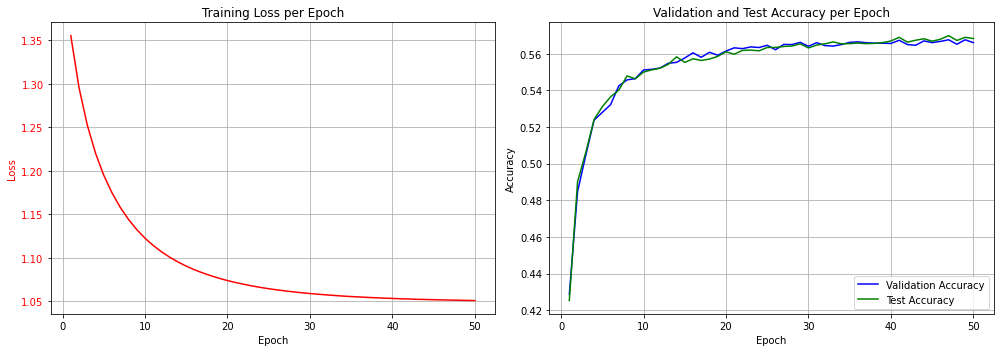

In [47]:
plot_metrics(cum_loss_list, acc_epoch_val, acc_epoch_test)

In [50]:
print("Validation Accuracy: ", evaluate(valid_dataloader))
print("Text Accuracy: ", evaluate(test_dataloader))

Validation Accuracy:  0.5660555555555555
Text Accuracy:  0.5682894736842106


In [53]:
print(acc_epoch_val)
print('=' * 100)
print(acc_epoch_test)

[0.4286111111111111, 0.4847222222222222, 0.5046666666666667, 0.5237222222222222, 0.528, 0.5321666666666667, 0.5424444444444444, 0.5457222222222222, 0.5463888888888889, 0.5511111111111111, 0.5515, 0.5521666666666667, 0.5547777777777778, 0.5552777777777778, 0.5576666666666666, 0.5605, 0.5580555555555555, 0.5607777777777778, 0.5591666666666667, 0.5614444444444444, 0.5632222222222222, 0.5627777777777778, 0.5637222222222222, 0.5633888888888889, 0.5646111111111111, 0.5621666666666667, 0.5650555555555555, 0.565, 0.5662222222222222, 0.5640555555555555, 0.5660555555555555, 0.5644444444444444, 0.5641666666666667, 0.565, 0.5662222222222222, 0.5665, 0.566, 0.5657777777777778, 0.5657222222222222, 0.5656111111111111, 0.5673333333333334, 0.565, 0.5646111111111111, 0.567, 0.5660555555555555, 0.5667222222222222, 0.5676111111111111, 0.5651666666666667, 0.5676111111111111, 0.5660555555555555]
[0.42526315789473684, 0.4901315789473684, 0.5061842105263158, 0.5240789473684211, 0.5310526315789473, 0.536447368